In [1]:
import xarray as xr
import rioxarray as rio
import pandas as pd
import numpy as np
from glob import glob

import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent) + "/code/")
from utils import *
import pyreadr

# Testing notebook `03_aggregate_regions`

## 1. Define functions

In [2]:
def calc_global(fn:str, regional:bool) -> pd.DataFrame:
    """
    Calculate the global biomass for a given file

    Parameters:
    fn: str: the file name
    regional: bool: if the file is regional or global

    Returns:
    pd.DataFrame: the global biomass for each landcover type
    """

    if regional:
        # load data
        df = pd.read_csv(file,index_col=[0,1])

        # convert the columns to int
        df.columns = df.columns.astype(int)

        # set the index names
        df.index.names = ['region','landcover']

        # group over landcover and sum
        res = df.groupby('landcover').sum()
    else:
        # load the dataarray
        da = xr.open_dataarray(fn, decode_times=False).transpose('landcover', 'time', 'y', 'x')

        # calculate the total biomass for each landcover type
        res = (da * calc_area(da) * 100).sum(dim=['x', 'y']).to_dataframe(name='biomass')['biomass'].unstack()

    return res

## 2. Run analysis

In [3]:
# find all files
files = glob('../results/03_aggregate_regions/*regions.csv')

for file in files:
    # find matching file
    matching_file = file.replace('_regions.csv', '.nc').replace('03_aggregate_regions','02_convert_AGB_TB')

    # check if regional or global
    regional = True if ('besnard' in file) | ('pan' in file) | ('FRA' in file) else False

    # calculate global biomass
    global_biomass = calc_global(matching_file,regional)

    # read the regional data results and groupby landcover
    regional_biomass = pd.read_csv(file,index_col=[0,1]).groupby(level=1).sum()
    # convert the columns to integers
    regional_biomass.columns = regional_biomass.columns.astype(int)

    # calculate the error between the global calculation and the regional one
    error = (global_biomass - regional_biomass).abs().sum().sum()

    print(f'{file}: {error:.2e}')

    assert error < 1e5, f'Error too high: {file} = {error:.2e}'

../results/03_aggregate_regions/liu_biomass_xu_ma_TB_regions.csv: 1.42e+04
../results/03_aggregate_regions/liu_biomass_xu_huang_TB_regions.csv: 1.95e+04
../results/03_aggregate_regions/liu_biomass_song_ma_TB_regions.csv: 1.21e+04
../results/03_aggregate_regions/liu_biomass_song_huang_TB_regions.csv: 9.36e+03
../results/03_aggregate_regions/liu_biomass_CCI_ma_TB_regions.csv: 1.80e+04
../results/03_aggregate_regions/liu_biomass_CCI_huang_TB_regions.csv: 1.44e+04
../results/03_aggregate_regions/xu_biomass_xu_TB_regions.csv: 4.16e+04
../results/03_aggregate_regions/xu_biomass_song_TB_regions.csv: 3.51e+04
../results/03_aggregate_regions/xu_biomass_CCI_TB_regions.csv: 2.77e+04
../results/03_aggregate_regions/chen_biomass_xu_TB_regions.csv: 1.00e+00
../results/03_aggregate_regions/chen_biomass_song_TB_regions.csv: 1.00e+00
../results/03_aggregate_regions/chen_biomass_CCI_TB_regions.csv: 1.75e+00
../results/03_aggregate_regions/LVOD_xu_ma_TB_regions.csv: 1.15e+03
../results/03_aggregate_regio

### 2.1. For DGVMs

In [4]:
# load regional nbp and cVeg data
trendy_nbp_regional = pd.read_csv('../results/03_aggregate_regions/regional_DGVM_nbp.csv',index_col=[0,1])
trendy_cVeg_regional = pd.read_csv('../results/03_aggregate_regions/regional_DGVM_cVeg.csv',index_col=[0,1])
trendy_nbp_regional.columns = trendy_nbp_regional.columns.astype(int)
trendy_cVeg_regional.columns = trendy_cVeg_regional.columns.astype(int)

# calculate the time difference and select the time period between 1993-2019
trendy_cVeg_regional = trendy_cVeg_regional.diff(axis=1)
trendy_cVeg_regional = trendy_cVeg_regional.iloc[:,1:]

In [5]:
# load global estimates from the models
trendy_global_nbp = pyreadr.read_r('../data/DGVMs/nbp_S3.RData')['nbp_S3'].T*1e15
trendy_global_cVeg = pyreadr.read_r('../data/DGVMs/cVeg_S3.RData')['cVeg_S3'].T*1e15
trendy_global_cVeg = trendy_global_cVeg.dropna()

# convert units from kgC per second to PgC per year
trendy_global_nbp = trendy_global_nbp*(3600*24*365*1e3/1e15)

# flip 'LPJ-GUESS' and 'LPJ' to match the order of the global data
models = np.array(trendy_nbp_regional.index.levels[1])
LPJ_ind = np.argwhere(models == 'LPJ')
LPJ_GUESS_ind = np.argwhere(models == 'LPJ-GUESS')
models[LPJ_ind] = 'LPJ-GUESS'
models[LPJ_GUESS_ind] = 'LPJ'

trendy_global_cVeg.index = models[models!='JULES-ES-1.1']
trendy_global_nbp.index = models
trendy_global_nbp.columns = trendy_nbp_regional.columns
trendy_global_cVeg.columns = trendy_nbp_regional.columns

trendy_global_cVeg = trendy_global_cVeg.diff(axis=1).dropna(axis=1)

In [6]:
# make sure the difference between the regional and global estimates is no larger than 1e14

assert all((trendy_global_cVeg.mean(axis=1)-trendy_cVeg_regional.groupby('model').sum().mean(axis=1)).abs().sort_values() < 1e14), "FAIL"
assert all((trendy_global_nbp.mean(axis=1)-trendy_nbp_regional.groupby('model').sum().mean(axis=1)).abs().sort_values() < 1e14), "FAIL"

Compare to O'Sullivan

/tmp/ipykernel_879063/2378118380.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (x[i], y[i]))


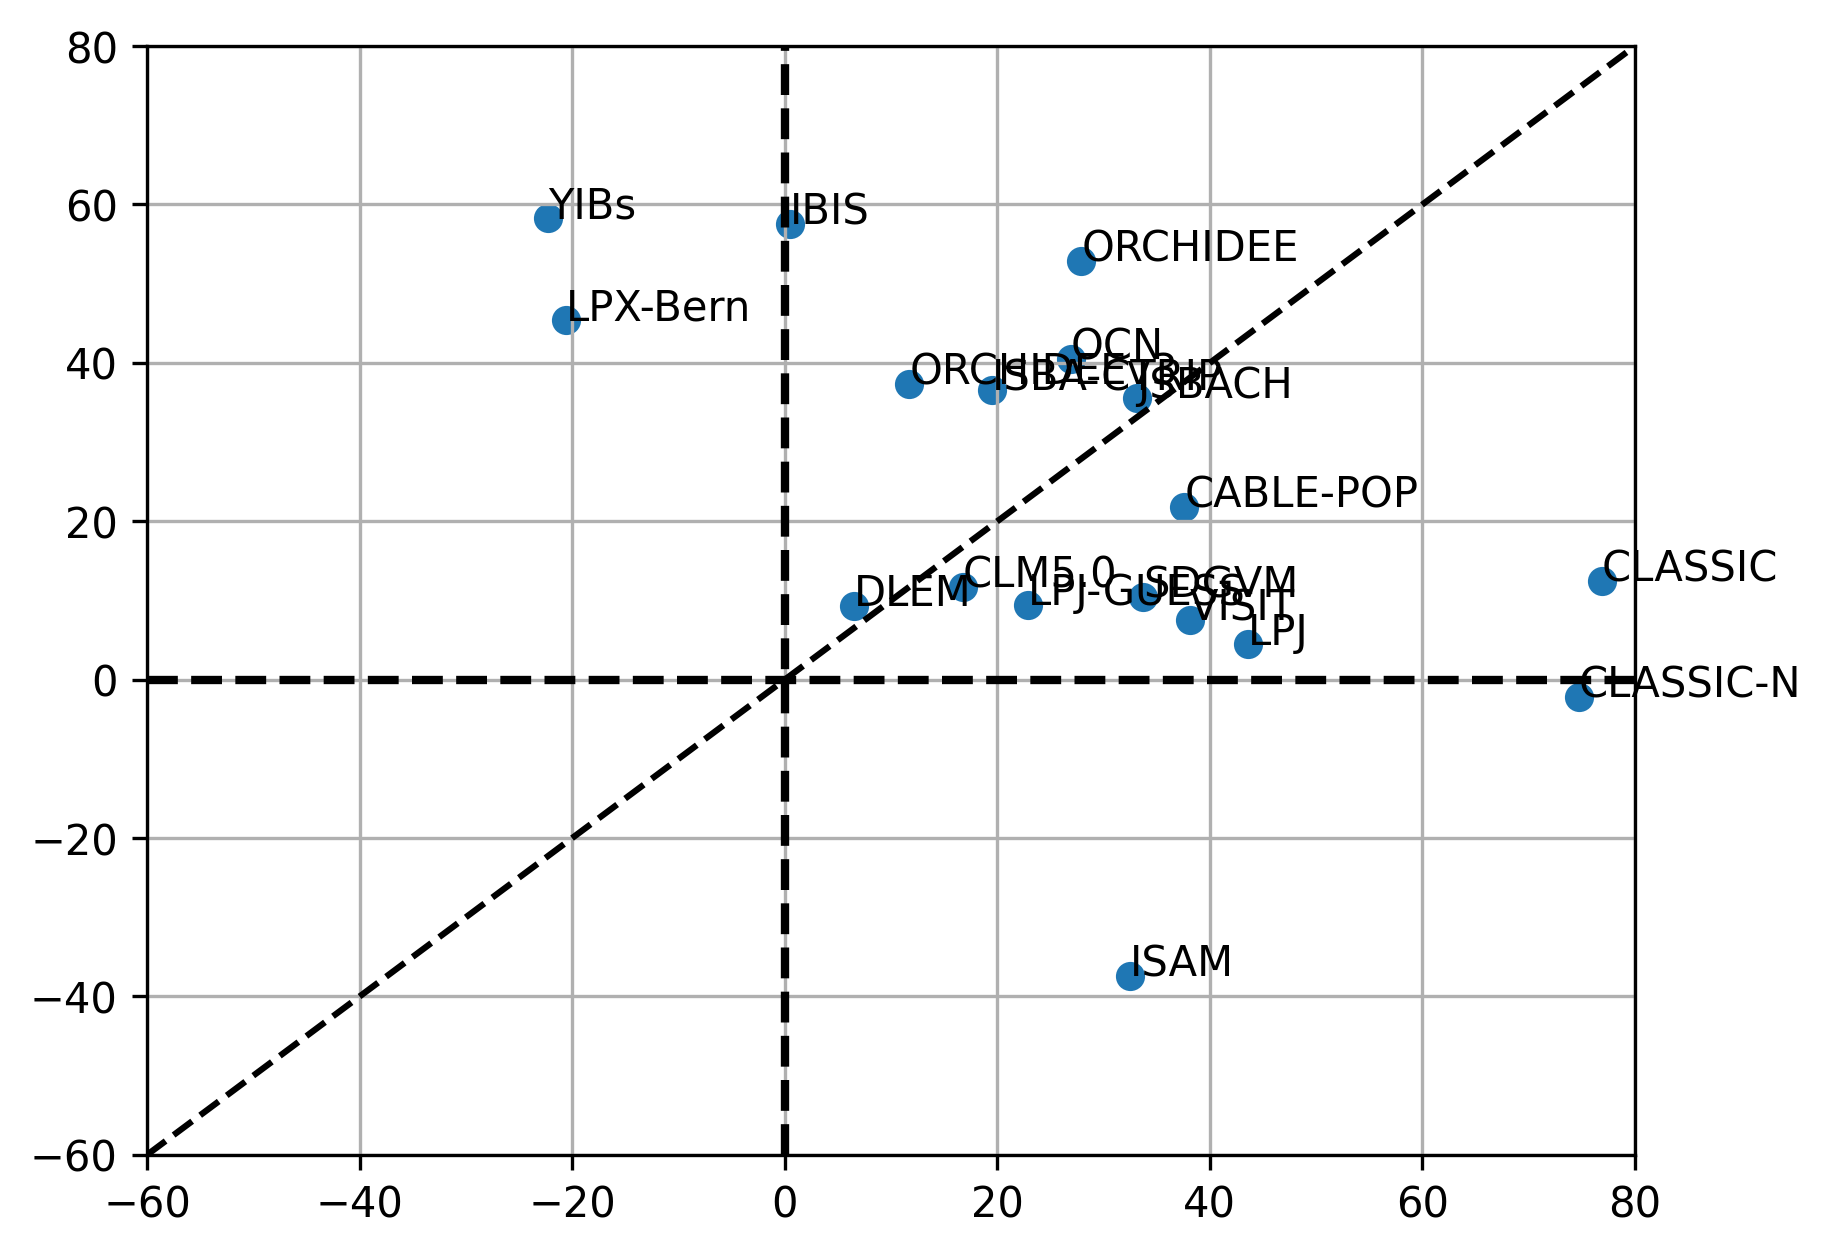

In [31]:
import matplotlib.pyplot as plt

trendy_global_cSoil = (trendy_global_nbp - trendy_global_cVeg).loc[:,1960:2020].dropna()
fig,ax = plt.subplots(dpi=300)
x = trendy_global_cVeg.loc[:,1960:2020].cumsum(axis=1).iloc[:,-1]/1e15
y = trendy_global_cSoil.loc[:,1960:2020].cumsum(axis=1).iloc[:,-1]/1e15
ax.scatter(x,y,label='cVeg')
ax.set(xlim=[-60,80],ylim=[-60,80])

ax.plot([-60,80],[-60,80],color='black',linestyle='--')
ax.grid('--')
ax.axhline(0,ls='--',lw=2,c='k')
ax.axvline(0,ls='--',lw=2,c='k')

for i, txt in enumerate(trendy_global_cVeg.index):
    ax.annotate(txt, (x[i], y[i]))
